In [1]:
# 使用spiking 0.14稳定版本，需要手动修改函数fromstring 替换为 frombuffer
import numpy as np

def load_events_fixed(file_name):
    with open(file_name, 'rb') as f:
        content = f.read()

    # 跳过 header
    lines = content.split(b'\n')
    idx = 0
    for i, line in enumerate(lines):
        if not line.startswith(b'#') and len(line.strip()) > 0:
            idx = i
            break
    data = b'\n'.join(lines[idx:])
    # 确保长度是 8 的倍数
    extra = len(data) % 8
    if extra != 0:
        data = data[:-extra]

    # 解析 big-endian int32
    events = np.frombuffer(data, dtype='>i4').reshape(-1,2)
    addresses, timestamps = events[:,0], events[:,1]

    # 解析 x, y, p
    x = addresses & 0x7f
    y = (addresses >> 7) & 0x7f
    p = (addresses >> 14) & 1
    t = timestamps.astype(np.int64)

    return {'t': t, 'x': x, 'y': y, 'p': p}

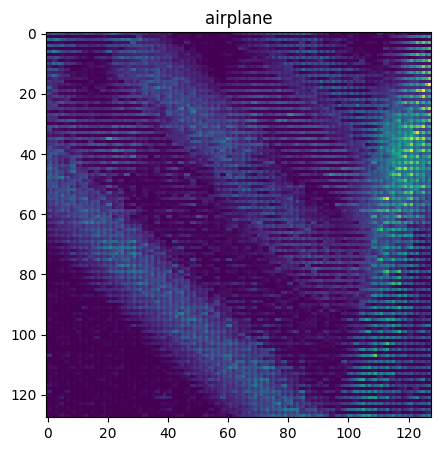

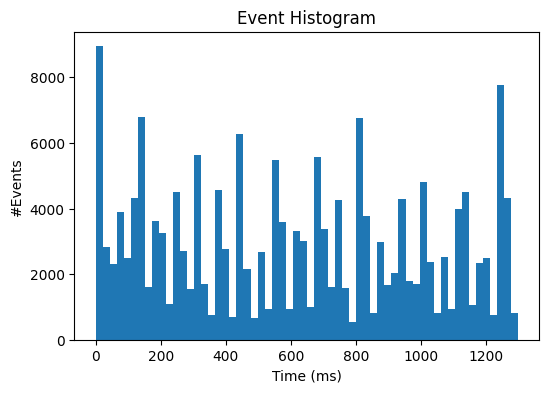

In [14]:
# 参考文档 https://www.guyuehome.com/detail?id=1948753266978390018

import matplotlib.pyplot as plt
from spikingjelly.datasets import integrate_events_by_fixed_frames_number
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS

f = './CIFAR10DVS/extract/airplane/cifar10_airplane_0.aedat'
events = load_events_fixed(f)

# 积分为 20 帧（按事件数均分）
frames = integrate_events_by_fixed_frames_number(
            events, split_by='number', frames_num=20,
            H=128, W=128)                           # [20, 2, 128, 128]

# 可视化所有帧的总和
plt.figure(figsize=(5,5))
plt.imshow(frames.sum(0).sum(0), cmap='viridis')
plt.title('airplane')
plt.show()  # 在 Jupyter 中直接显示图

# 绘制事件时间分布直方图
plt.figure(figsize=(6,4))
plt.hist(events['t']/1e3, bins=60)
plt.xlabel('Time (ms)')
plt.ylabel('#Events')
plt.title('Event Histogram')
plt.show()

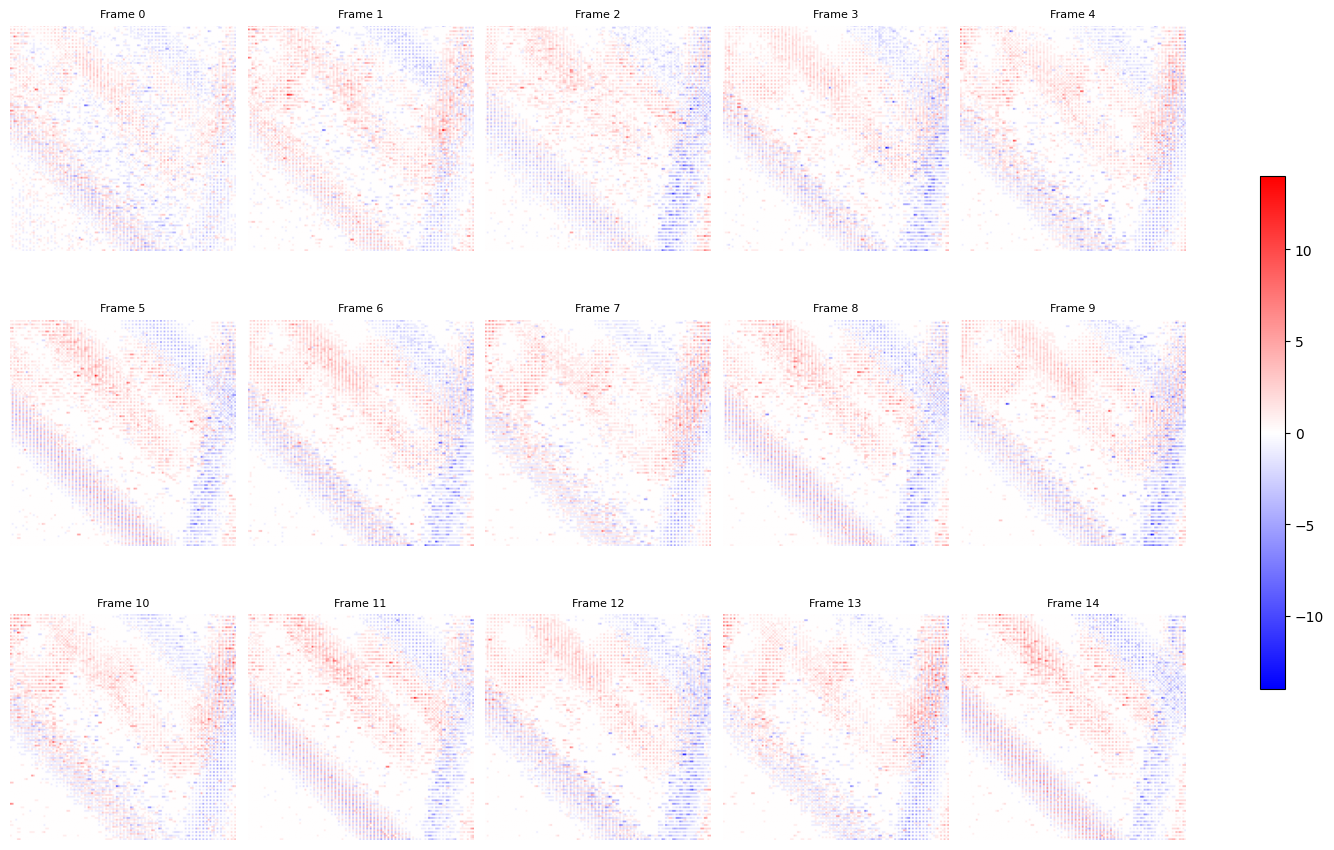

In [23]:
import matplotlib.pyplot as plt
from spikingjelly.datasets import integrate_events_by_fixed_frames_number
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS

# 1) 读取 .aedat 事件文件
f = './CIFAR10DVS/extract/airplane/cifar10_airplane_0.aedat'
events = load_events_fixed(f)          # {'t','x','y','p'} dict

# 2) 事件积分为 20 帧（事件数均分）
frames = integrate_events_by_fixed_frames_number(
    events, split_by='number', frames_num=15, H=128, W=128
)  # shape: [20, 2, 128, 128]

# 3) 构造 4×5 网格可视化
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
vmax = frames.max()  # 对称归一化让色阶一致
for idx, ax in enumerate(axes.flat):
    ax.axis('off')
    if idx < len(frames):
        # 正极性保持正值，负极性取负值
        merged = frames[idx][0] - frames[idx][1]
        im = ax.imshow(merged, cmap='bwr', vmin=-vmax, vmax=vmax)
        ax.set_title(f'Frame {idx}', fontsize=8)

plt.tight_layout()
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)  # 全局色条
plt.show()

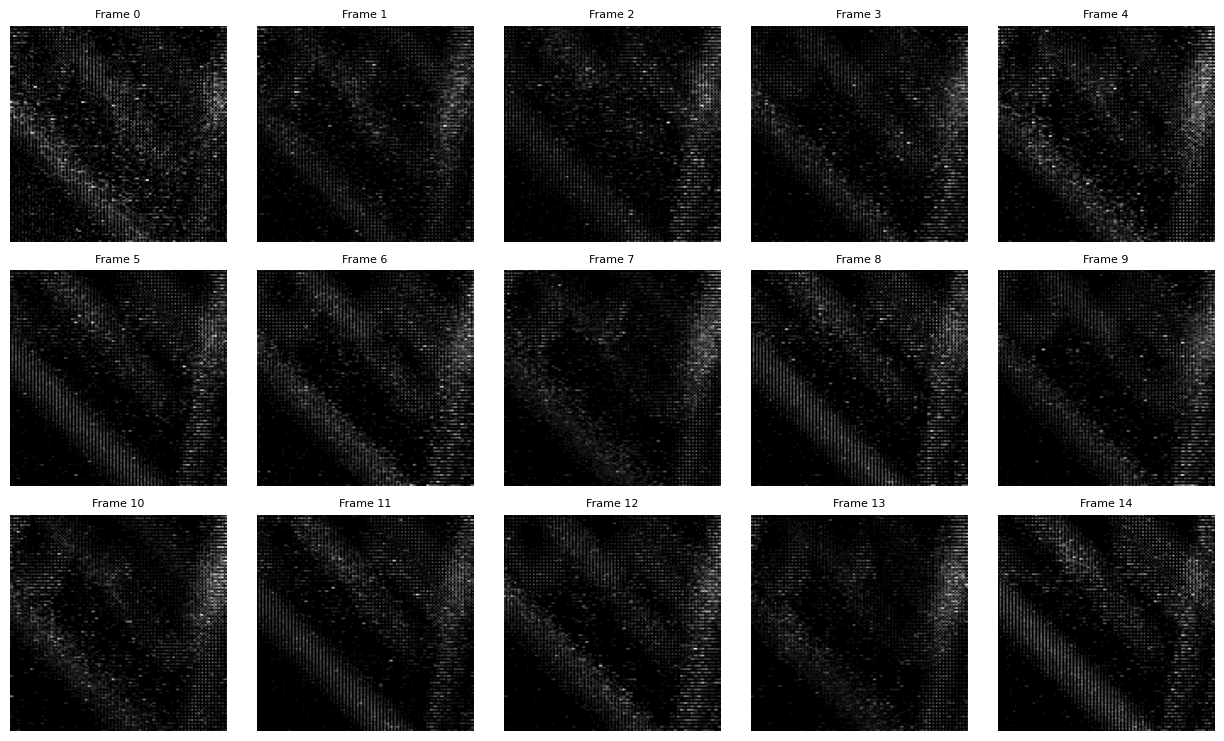

In [24]:
# 3) 构造 4×5 网格可视化
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

for idx, ax in enumerate(axes.flat):
    ax.axis('off')
    if idx < frames.shape[0]:
        # 合并正/负极性 → 灰度
        img = frames[idx].sum(0)        # [128,128]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Frame {idx}', fontsize=8)

plt.tight_layout() 
plt.show()